In [1]:
import os
import io
import torch
import torchvision
import numpy as np
import random
import tarfile

import tarfile as tf
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch.nn.functional as F

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.transforms import ToTensor
from torchvision import ops
from torch.nn.utils.rnn import pad_sequence
from IPython.display import display
from sklearn.model_selection import train_test_split
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dataset

In [9]:
class SpacecraftImagesDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        """
        Object for handling the spacecraft images dataset
        https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

        Args:
            annotations_file (str): Path to data labels
            img_dir (str): Path to images
            transform (lambda): Transform to be applied to images
        """
        self.img_labels = pd.read_csv(annotations_file)
        self.img_labels = self.img_labels
        # self.img_labels = self.img_labels.head(1579)
        self.img_dir = img_dir
        self.pil_to_tensor = ToTensor()
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # Get the image name and bbox associated with the given idx
        img_name = self.img_labels.iloc[idx, 0]
        bbox = self.img_labels[self.img_labels.image_id == img_name].values[:,1:].astype("float")

        # Get which tar file to grab image from hello
        tar_path = os.path.join(self.img_dir, img_name[0] + ".tar")
        
        # Grab image from tar file
        with tf.open(tar_path, "r") as src_tar:
            member = src_tar.getmember("images/" + img_name + ".png")
            image = src_tar.extractfile(member)
            image = self.pil_to_tensor(Image.open(io.BytesIO(image.read())))

        # Apply transform if input
        if self.transform:
            image = self.transform(image)

        # Define labels in the image
        labels = torch.ones((bbox.shape[0]), dtype=torch.int64)

        target = {}
        target["boxes"] = torch.tensor(bbox, dtype=torch.float32)
        target["label"] = labels

        return image, target

__User defined parameters:__
- `train_size` = 80% of total dataset size
- `val_size` = 20% of total dataset size

In [10]:
label_path = "../compressed_data/images/train_labels.csv"
img_dir = "../compressed_data/images"

# Load in the full dataset object
sc_dataset = SpacecraftImagesDataset(label_path, img_dir)

# Take a subset of the dataset to save time
sub_idxs = list(range(0, 1579))
sub_sc_dataset = torch.utils.data.Subset(sc_dataset, sub_idxs)

# Calculate the size of the training and validation datasets
# 80% of data for training
train_size = int(0.8 * len(sub_sc_dataset))
# 20% of data for validation
val_size = len(sub_sc_dataset) - train_size

# Make training and validation datasets
train_dataset, val_dataset = torch.utils.data.random_split(sub_sc_dataset, [train_size, val_size])

## Dataloader
__User defined parameters:__  
- `batch_size` = 64

In [13]:
def collate_fn(data):
    return data

sc_dataloader = DataLoader(sc_dataset, 
                            batch_size=1, 
                            shuffle=False, 
                            num_workers=4,
                            collate_fn=collate_fn,
                            pin_memory=(True if torch.cuda.is_available() else False))

# Create the training and validation dataloader objects
train_dataloader = DataLoader(train_dataset, 
                              batch_size=16, 
                              shuffle=True,
                              num_workers=4,
                              collate_fn=collate_fn,
                              pin_memory=(True if torch.cuda.is_available() else False))

val_dataloader = DataLoader(val_dataset, 
                            batch_size=16, 
                            shuffle=False, 
                            num_workers=4,
                            collate_fn=collate_fn,
                            pin_memory=(True if torch.cuda.is_available() else False))

## Load Pre-Trained Faster R-CNN Model
The model loaded and used for the base of the R-CNN is resnet-50-fpn.

The "head" of a model is the part of the model which classifies the data / separates the output from the rest of the network into different classes.

__User defined parameters:__
- `num_classes` = 2

In [6]:
# Load in pretrained model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Specify the number of classes being used
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the pre-trained head with new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

/home/bam3869/.conda/envs/spacecraft-detection/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bam3869/.conda/envs/spacecraft-detection/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Define Loss and Optimizer
__User defined parameters:__
- `lr` = 0.1

In [7]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

## Setup training loop
__User defined parameters:__
- `num_epochs` = 10

In [8]:
# Move model to the right device
model.to(device)

# Train for 10 epochs
num_epochs = 20

train_losses_list = []
val_losses_list = []

for epoch in range(num_epochs):
    model.train()
    for data in train_dataloader:        
        images = []
        targets = []
        for d in data:
            images.append(d[0].to(device))
            targ = {}
            targ["boxes"] = d[1]["boxes"].to(device)
            targ["labels"] = d[1]["label"].to(device)
            targets.append(targ)

        # Calculate the model loss
        train_loss_dict = model(images, targets)
        train_losses = sum(loss for loss in train_loss_dict.values())
        train_losses_list.append(train_losses.item)
        
        # Backpropagation
        optimizer.zero_grad()
        train_losses.backward()
        optimizer.step()

    # model.eval()
    # with torch.no_grad():
    #     for data in val_dataloader:
    #         images = []
    #         targets = []
    #         for d in data:
    #             images.append(d[0].to(device))
    #             targ = {}
    #             targ["boxes"] = d[1]["boxes"].to(device)
    #             targ["labels"] = d[1]["label"].to(device)
    #             targets.append(targ)
            
    #         val_loss_dict = model(images, targets)
    #         val_losses = sum(loss for loss in val_loss_dict)
    #         val_losses_list.append(val_losses)

    print(f'Epoch {epoch+1}, Train Loss: {train_losses.item()}, Save State: {(epoch % 5) + 1}')
    torch.save(model.state_dict(), f'saved_states/model_weights_{(epoch % 5) + 1}.pth')

Epoch 1, Train Loss: 0.13547024130821228, Save State: 1
Epoch 2, Train Loss: 0.056043341755867004, Save State: 2
Epoch 3, Train Loss: 0.07617159932851791, Save State: 3
Epoch 4, Train Loss: 0.07279586791992188, Save State: 4
Epoch 5, Train Loss: 0.09055981040000916, Save State: 5
Epoch 6, Train Loss: 0.06061745062470436, Save State: 1
Epoch 7, Train Loss: 0.046519260853528976, Save State: 2
Epoch 8, Train Loss: 0.04707856476306915, Save State: 3
Epoch 9, Train Loss: 0.045704927295446396, Save State: 4
Epoch 10, Train Loss: 0.037867575883865356, Save State: 5
Epoch 11, Train Loss: 0.05895233154296875, Save State: 1
Epoch 12, Train Loss: 0.02855152264237404, Save State: 2
Epoch 13, Train Loss: 0.034894537180662155, Save State: 3
Epoch 14, Train Loss: 0.02868451178073883, Save State: 4
Epoch 15, Train Loss: 0.030484244227409363, Save State: 5
Epoch 16, Train Loss: 0.024783380329608917, Save State: 1
Epoch 17, Train Loss: 0.027303703129291534, Save State: 2
Epoch 18, Train Loss: 0.02750021

## Testing the model

tensor([159.3813, 115.7670, 193.1453, 189.2086], device='cuda:0')


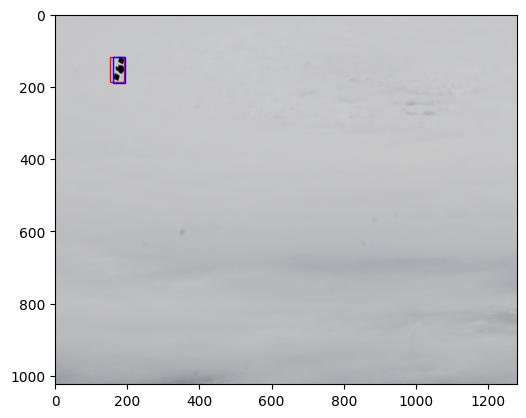

In [157]:
test_img_idx = [5000]
test_img_subset = torch.utils.data.Subset(sc_dataset, test_img_idx)
test_img_dataloader = DataLoader(test_img_subset, 
                                 batch_size=1, 
                                 shuffle=False, 
                                 num_workers=4,
                                 collate_fn=collate_fn,
                                 pin_memory=(True if torch.cuda.is_available() else False))

data = next(iter(test_img_dataloader))

test_img = []
test_target = []
for d in data:
    test_img.append(d[0].to(device))
    test_targ = {}
    test_targ["boxes"] = d[1]["boxes"].to(device)
    test_targ["labels"] = d[1]["label"].to(device)
    test_target.append(test_targ)

fig, ax = plt.subplots()

model.eval()
with torch.no_grad():
    predictions = model(test_img)

# print(predictions)

ax.imshow(data[0][0].permute(1, 2, 0))

for coords in data[0][1]["boxes"]:
    bbox_w = coords[2] - coords[0]
    bbox_h = coords[3] - coords[1]
    ground_truth_bbox = patches.Rectangle((coords[0], coords[1]), bbox_w, bbox_h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(ground_truth_bbox)

for coords_idx in range(len(predictions[0]["boxes"])):
    bbox_boxes = predictions[0]["boxes"][coords_idx].cpu()
    bbox_w = bbox_boxes[2] - bbox_boxes[0]
    bbox_h = bbox_boxes[3] - bbox_boxes[1]
    ground_truth_bbox = patches.Rectangle((bbox_boxes[0], bbox_boxes[1]), bbox_w, bbox_h, linewidth=1, edgecolor='b', facecolor='none')
    ax.add_patch(ground_truth_bbox)

    